In [616]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from photutils import CircularAperture, aperture_photometry
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm_notebook

plt.rcParams['axes.linewidth']=3
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rc('xtick.major', size=8, pad=8)
plt.rc('xtick.minor', size=6, pad=5)
plt.rc('ytick.major', size=8, pad=8)
plt.rc('ytick.minor', size=6, pad=5)
plt.rcParams['font.size'] = 18


parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

In [2]:
def feature_tab(element):

    files = np.sort([i for i in os.listdir('.') if i.endswith(element)])[1:]

    tab = Table()
    limb_vals = np.array([], dtype='U10')

    for i, fn in enumerate(files):
        dat = Table.read(fn, format='ascii')
        
        if element == 'halpha':
            val = str(fn.split('u')[-1].split('a')[0][:4])
        else:
            val = fn.split('u')[2].split('c')[0][:-1]

        if val[-1] == '.':
            val = val[:-1] + '0'
        if len(val) == 3:
            val = val + '0'
                
        key = 'limb_' + val

        if i == 0:
            tab.add_column(Column(dat['col1'], 'wavelength'))
        tab.add_column(Column(dat['col2'], key))
        
        limb_vals = np.append(limb_vals, val)
    
    return tab, limb_vals

In [3]:
def feature_region(tab, wstart, wstop):
    return tab[(tab['wavelength']>=wstart) & 
               (tab['wavelength']<=wstop)]

In [4]:
def discrete_star(res, limb_vals):

    x = np.linspace(-1.0, 1.0, res)
    y = np.linspace(-1.0, 1.0, res)

    z = np.ones(res**2).reshape(res,res)

    xx, yy = np.meshgrid(x, y, sparse=True)

    r = np.sqrt(xx**2 + yy**2)
    z[r >1] = 0

    lat = np.arcsin(yy)
    lon = np.arcsin(xx)

    v_diffrot = 100*z*np.cos(lat)*np.sin(lon) *np.cos(lat/1.0)
    v = 100*z*np.cos(lat)*np.sin(lon)

    limb = 1.0*(1-0.64*(1-np.cos(r*np.pi/2)))
    limb[r>1] = 0

    discrete_limb = np.zeros(limb.shape)

    for i in range(len(limb_vals)-1):
        discrete_limb[(limb >= float(limb_vals[i])) & 
                      (limb <  float(limb_vals[i+1]))] = float(limb_vals[i])
        
    return discrete_limb

In [538]:
tab, limb_vals = feature_tab(element='calcium')
tab = feature_region(tab, 8494, 8502)
#tab = feature_region(tab, 6560, 6566)
discrete_limb = discrete_star(801, limb_vals)

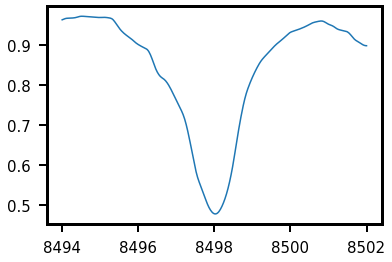

In [539]:
plt.plot(tab['wavelength'], tab['limb_0.10'])

In [549]:
tab.colnames

['wavelength',
 'limb_0.00',
 'limb_0.05',
 'limb_0.10',
 'limb_0.15',
 'limb_0.20',
 'limb_0.25',
 'limb_0.30',
 'limb_0.35',
 'limb_0.40',
 'limb_0.45',
 'limb_0.50',
 'limb_0.55',
 'limb_0.60',
 'limb_0.65',
 'limb_0.70',
 'limb_0.75',
 'limb_0.80',
 'limb_0.85',
 'limb_0.90',
 'limb_0.95',
 'limb_1.00']

In [559]:
plotting_limb = np.full(discrete_limb.shape, np.nan)
x, y = np.where(discrete_limb != 0)
plotting_limb[x,y] = discrete_limb[x,y]

In [612]:
colors

array(['#800026', '#a60026', '#c60624', '#dd161e', '#ef3222', '#fc532b',
       '#fd7a36', '#fd9841', '#feaf4b', '#fec763', '#fedc7c', '#ffe896',
       '#fff4b1', '#ffffcc'], dtype='<U7')

In [666]:
from pylab import *
colormap='YlOrRd_r'

cmap = cm.get_cmap(colormap, 20)

colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb


clist = ['#000000', colors[5], colors[10]]

rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)


colors = []
for i in range(cm.N):
    rgb = cm(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

colors = np.unique(colors)
colors = colors[np.linspace(0,len(colors)-1,len(tab.colnames)-8,dtype=int)]

In [667]:
colors

array(['#000000', '#1c0403', '#380707', '#550b0b', '#710f0e', '#8c1312',
       '#aa1715', '#c81b19', '#e21f1d', '#ea3423', '#ef4c2a', '#f36431',
       '#f87d38', '#fd953f'], dtype='<U7')

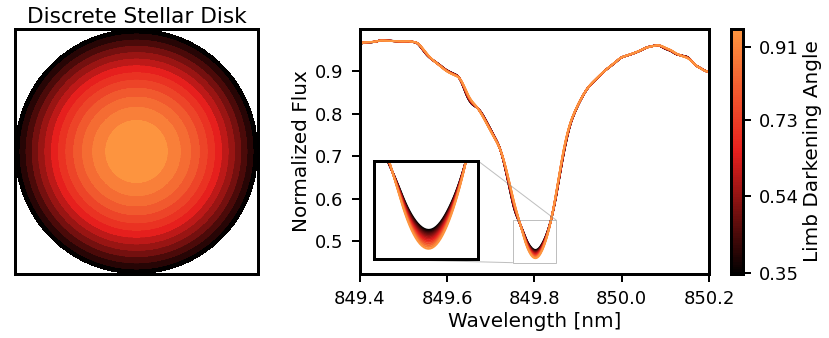

In [693]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4.5),
                               gridspec_kw={'width_ratios':[1,1.8]})


im = ax1.contourf(plotting_limb, 100, cmap=cm)
ax1.set_xticks([]);ax1.set_yticks([])


axins = ax2.inset_axes([0.04, 0.06, 0.3, 0.4])
axins.set_xticks([]);axins.set_yticks([])

for i in range(len(colors)):
    ax2.plot(tab['wavelength']/10, tab[tab.colnames[i+2]], c=colors[i],
             lw=2)
    axins.plot(tab['wavelength']/10, tab[tab.colnames[i+2]], c=colors[i],
             lw=2)

axins.set_xlim(849.75, 849.85)
axins.set_ylim(0.45,0.55)
ax2.indicate_inset_zoom(axins)
ax2.set_xlabel('Wavelength [nm]', fontsize=20)
ax2.set_ylabel('Normalized Flux', fontsize=20)
ax1.set_title('Discrete Stellar Disk')
ax2.set_xlim(849.4,850.2)
cbar = plt.colorbar(im)
cbar.set_label('Limb Darkening Angle', fontsize=20)
cbar.set_ticks(np.round(np.linspace(0.35, 1.1, 5),2))
plt.subplots_adjust(wspace=0.3)
plt.savefig('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/clvs.pdf',
            rasterize=True, bbox_inches='tight', dpi=250)

In [687]:
np.round(np.linspace(0.32, 1.1, 4),1)

array([0.3, 0.6, 0.8, 1.1])

In [541]:
def make_cube(limb_vals, discrete_limb, shape, tab):
    stellar_cube = np.zeros(shape)
    vals = np.sort([float(i) for i in limb_vals])
    for l in vals[vals != 0]:
        x, y = np.where(discrete_limb == l)

        if len(str(l)) < 4:
            l = str(l) + '0'

        stellar_cube[x,y] = tab['limb_{}'.format(l)]
    
    return stellar_cube

In [542]:
cube = make_cube(limb_vals, discrete_limb, (801,801,len(tab)), tab)

In [436]:
rstar = discrete_limb.shape[0]/2.0
astar = np.pi * rstar**2

rplanet = 0.0300  * rstar
aplanet = np.pi * rplanet**2

psize = aplanet/astar * discrete_limb.shape[0] # radius of planet in pixel space
psize

0.7208999999999998

In [443]:
planet_mask = np.ones(discrete_limb.shape)

psize = 1.0
ap = np.array( CircularAperture((psize,psize), psize).to_mask(method='exact') )

ap[ap<0.5] = np.nan
ap[ap>=0.5]= 1

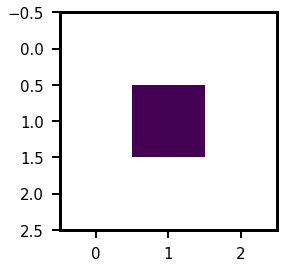

In [444]:
plt.imshow(ap)

In [676]:
#def time_step_masks(tstep, ap):
cx = int(len(discrete_limb)/2-ap.shape[1]/2)
tsteps = np.linspace(cx, len(discrete_limb)+ap.shape[0]/2, 50, dtype=int)
q = tsteps<790
spec_timesteps = np.zeros((len(tsteps), len(tab)))

masks = np.full((len(tsteps[q]),
                 discrete_limb.shape[0],
                 discrete_limb.shape[1]), np.nan)

mid = int(len(discrete_limb)/2 - ap.shape[0]/2 + 0.5)
b = 0.2 # Livingston Spitzer

start = int(mid * b)
print(start)

for i, ts in tqdm_notebook(enumerate(tsteps[q])):
    
    mask = np.full(discrete_limb.shape, np.nan)
    
    if ts+ap.shape[1] > discrete_limb.shape[0]:
        diff = np.abs(discrete_limb.shape[0] - (ts+ap.shape[1]))
        partial = ap[:, :ap.shape[1]-diff]
        mask[start:start+ap.shape[0], ts:] = partial

    else:
        mask[start:start+ap.shape[0], ts:ts+ap.shape[1]] = ap
    
    masks[i] = mask + 0
    
all_masks = np.full((len(tsteps[q])*2,
                     discrete_limb.shape[0],
                     discrete_limb.shape[1]), np.nan)
x = np.flip(np.arange(0,len(masks),1,dtype=int))
for i in range(len(masks)):
    all_masks[-i] = masks[x[i]] + 0.0
    all_masks[i]  = np.flip(masks[x[i]]) + 0.0 

all_masks = np.delete(all_masks, i+1, axis=0)

159


In [677]:
np.where(np.isnan(all_masks)==False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94]),
 array([640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
        640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
        640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
        640, 640, 640, 640, 640, 640, 640, 640, 640, 160, 160, 160, 160,
        160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
        160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
        160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
        160, 160, 160, 160]),
 array([ 13,  22,  30,  38,  

In [545]:
spec_timesteps = np.zeros((len(all_masks), len(tab)))

for i in tqdm_notebook(range(len(all_masks))):
    x, y = np.where(np.isnan(all_masks[i])==True)
    spec = np.nansum(cube[x,y,:], axis=0)
    spec_timesteps[i] = spec + 0.0

In [532]:
from pylab import *
colormap='YlOrRd_r'

cmap = cm.get_cmap(colormap, len(spec_timesteps))
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

In [533]:
template = np.nanmedian(spec_timesteps, axis=0)

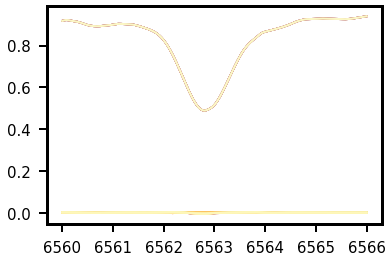

In [534]:
grid = np.zeros((len(all_masks), len(template)))

for i in range(len(all_masks)):
    diff = spec_timesteps[i] - template
    plt.plot(tab['wavelength'], 
             diff,
             color=colors[i], lw=2, alpha=0.6)
    grid[i] = spec_timesteps[i] - template

In [514]:
grid = np.delete(grid, [47,48], axis=0)

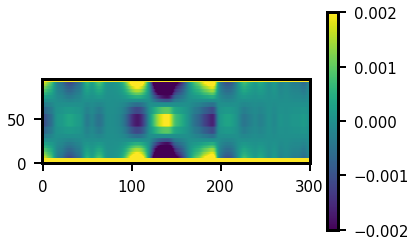

In [537]:
plt.imshow(grid, vmin=-0.002, vmax=0.002)
plt.ylim(0,len(spec_timesteps))
plt.colorbar()

# Making the movie

In [431]:
plt.rcParams['font.size'] = 15

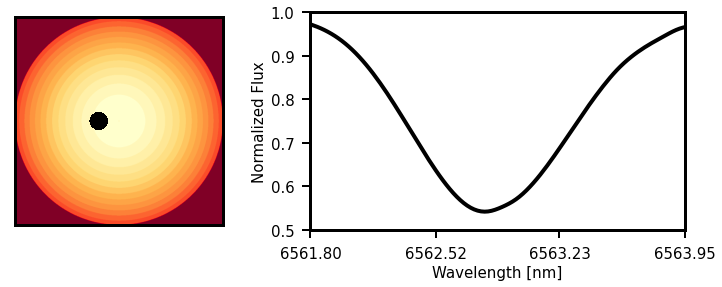

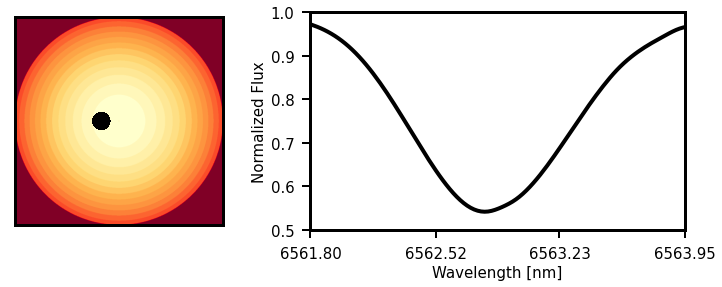

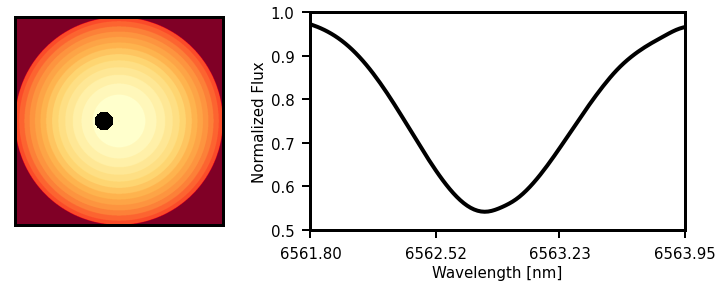

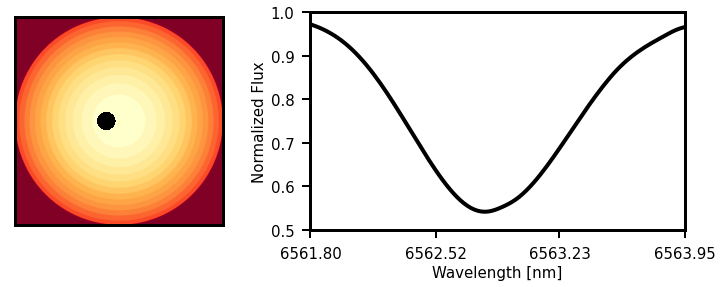

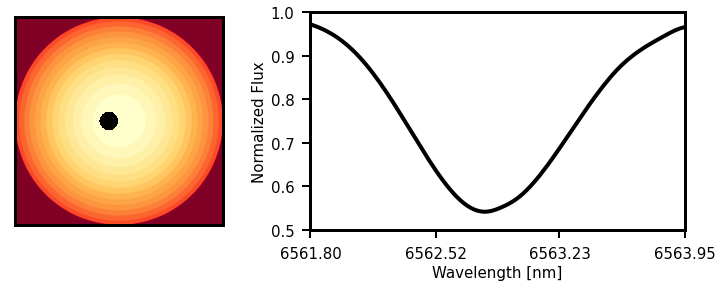

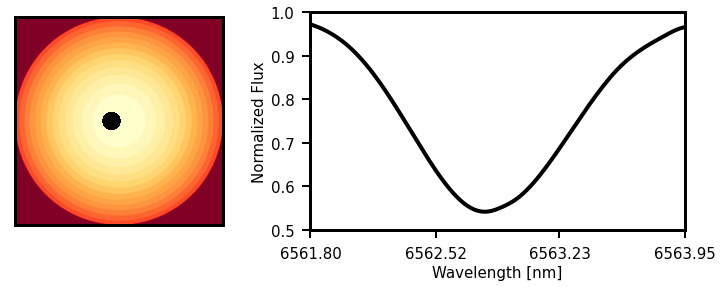

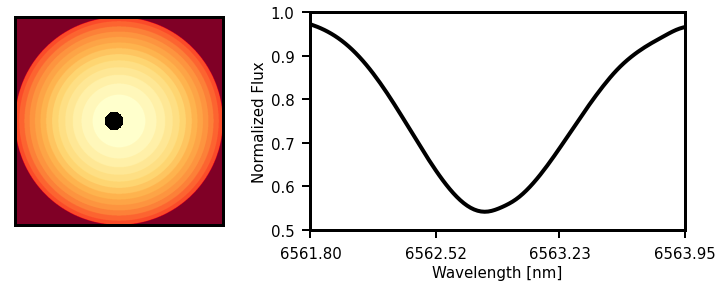

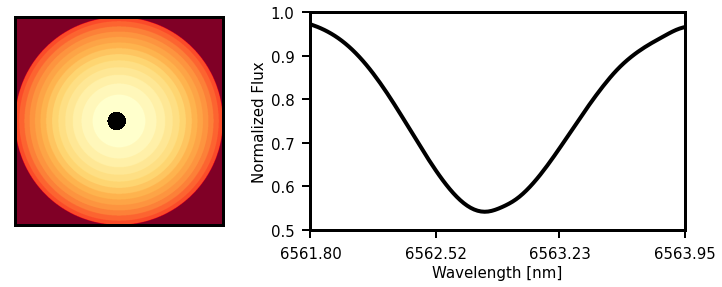

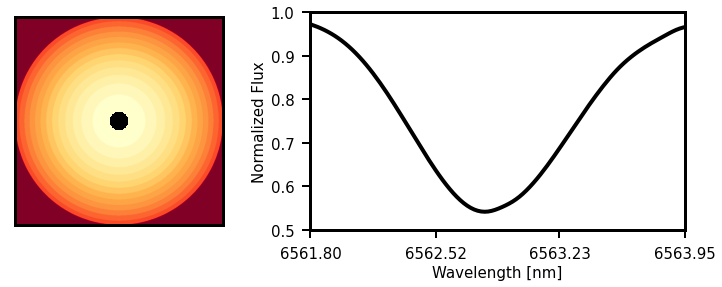

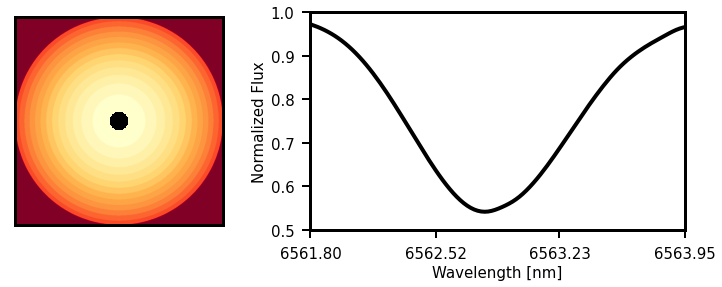

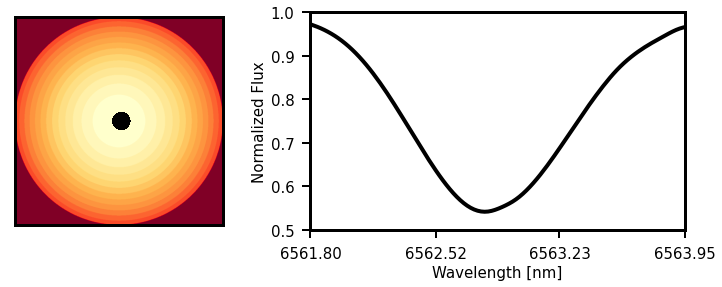

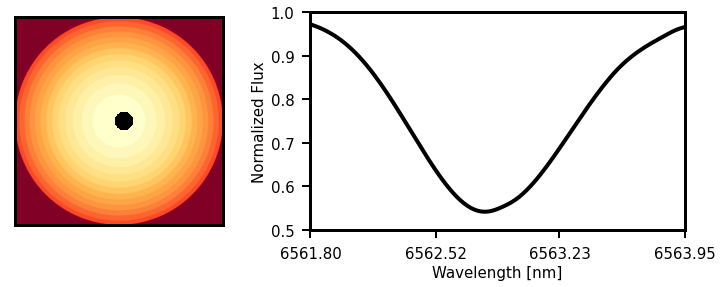

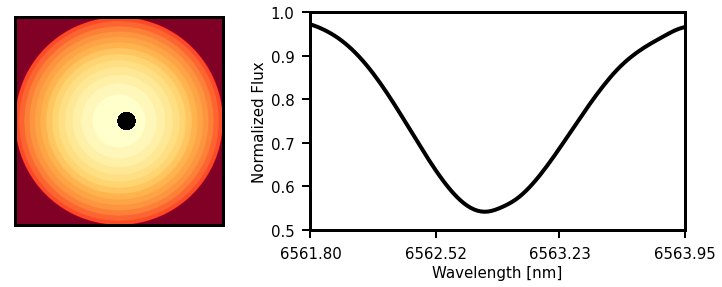

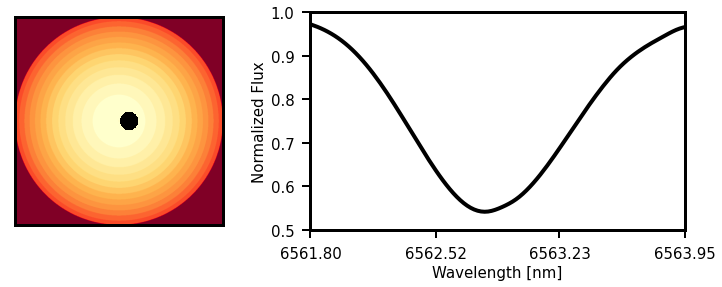

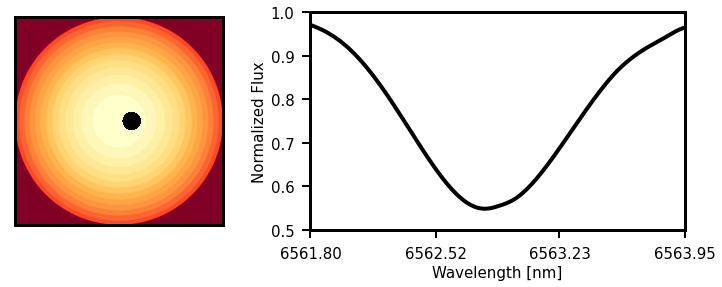

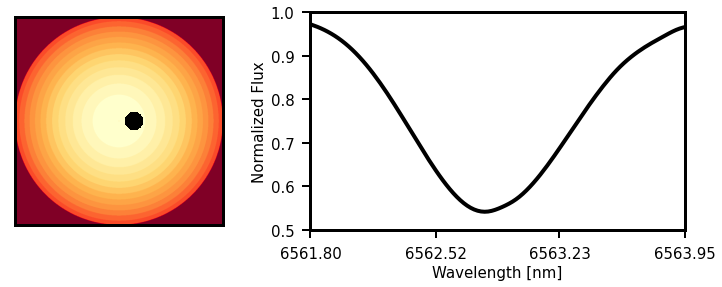

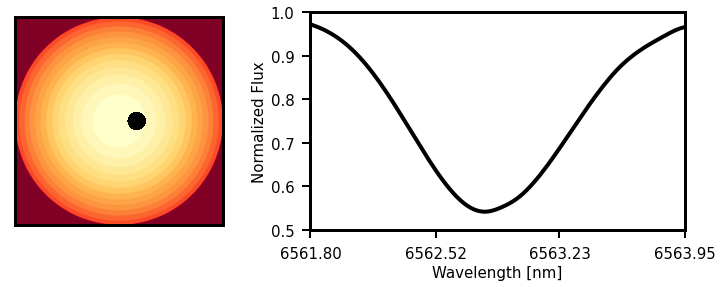

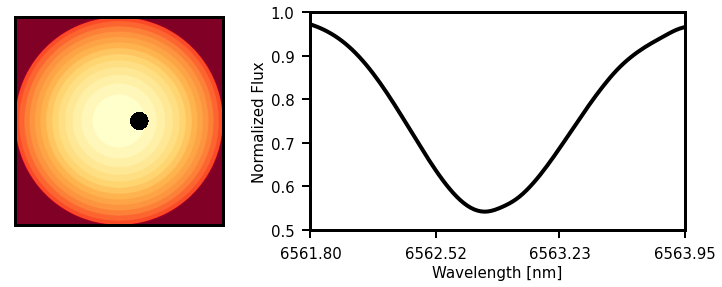

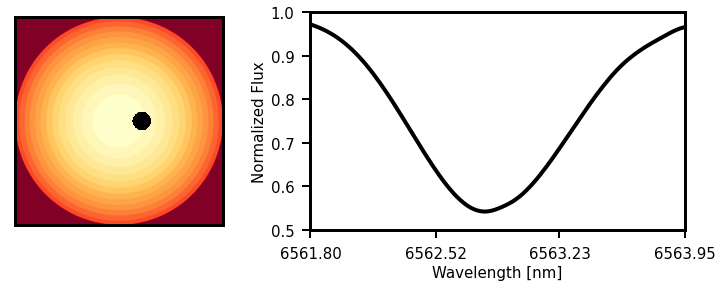

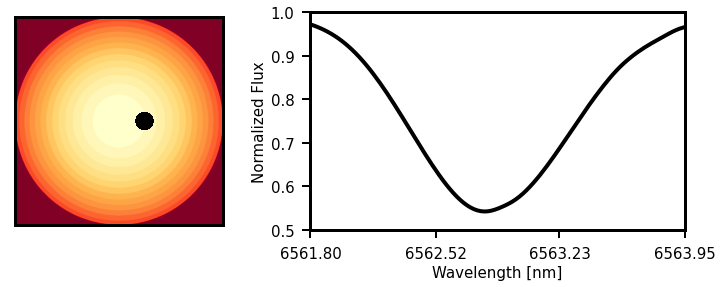

In [432]:
for i in range(35,55):

    fig, (ax1, ax2) = plt.subplots(ncols=2, 
                                   gridspec_kw={'width_ratios':[1,1.8]},
                                   figsize=(12,4))

    ax1.imshow(discrete_limb, cmap='YlOrRd_r')
    ax1.imshow(all_masks[i], cmap='Greys_r')
    ax1.set_xticks([]); ax1.set_yticks([])
    
    med = spec_timesteps[i]/np.nanmedian(spec_timesteps[i])

    if i != 0 and i != len(tsteps)-1:
        diff = -1* (spec_timesteps[i] - template)
        ax2.plot(tab['wavelength'], 
                 diff/np.nanmedian(diff),
                 color='k', lw=4)
    else:
        ax2.plot(tab['wavelength'],
                 template/np.nanmedian(template),
                 color='k', lw=4)
   # ax2.plot(tab['wavelength'], 
   #              template/np.nanmedian(template), 
   #              color='k', lw=2)
    ax2.set_xlim(6561.8,6563.95)
    ax2.set_ylim(0.5,1.0)
    ax2.set_xlabel('Wavelength [nm]')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_xticks(np.round(np.linspace(6561.8,6563.95,4),2))
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [396]:
np.nanmedian(diff)

0.0

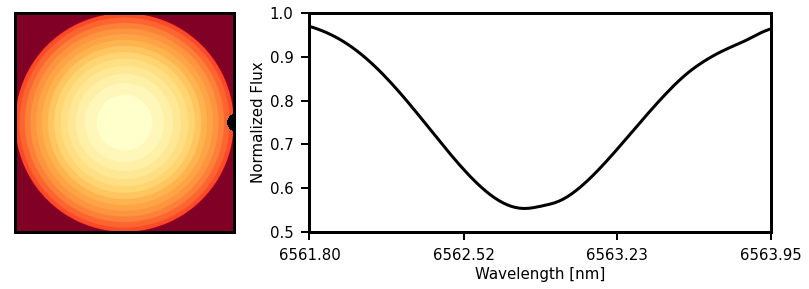

In [433]:
fig, (ax1, ax2) = plt.subplots(ncols=2, 
                               gridspec_kw={'width_ratios':[1,1.8]},
                               figsize=(12,4))
# X is (Nt, Ny, Nx)
im = ax1.imshow(discrete_limb, cmap='YlOrRd_r')
fig.tight_layout()
ax1.set_xticks([]); ax1.set_yticks([])
ax2.set_xlim(6561.8,6563.95)
ax2.set_ylim(0.5,1.0)
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Normalized Flux')
ax2.set_xticks(np.round(np.linspace(6561.8,6563.95,4),2))


def animate(i):
    if i > 0:
        ax2.clear()
    ax1.imshow(discrete_limb, cmap='YlOrRd_r')
    ax1.imshow(all_masks[i], cmap='Greys_r')
    diff = -1* (spec_timesteps[i] - template)
    
    if np.nanmedian(diff) == 0:
        ax2.plot(tab['wavelength'],
                 template / np.nanmedian(template),
                 color='k', lw=3)
    else:
        ax2.plot(tab['wavelength'],
                     diff / np.nanmedian(diff),
                     color='k', lw=3)
    ax2.set_xlim(6561.8,6563.95)
    ax2.set_ylim(0.5,1.0)
    ax2.set_xlabel('Wavelength [nm]')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_xticks(np.round(np.linspace(6561.8,6563.95,4),2))
    return im,

#ax1.set_xticks([]); ax1.set_yticks([])

anim = FuncAnimation(fig, animate, 
                     frames=np.arange(0, len(all_masks), 1), 
                     blit=True, interval=60)
HTML(anim.to_jshtml())

In [434]:
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [435]:
anim.save('/Users/arcticfox/Desktop/clv.mp4', writer=writer)